In [137]:
import keras as keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [138]:
first100images = loadmat('w135_first100images.mat')['DATAcropped']
print(first100images.shape)
first100images = np.transpose(first100images, (2,0,1))
print(first100images.shape)

(3320, 399, 100)
(100, 3320, 399)


In [139]:
# chops the images into pixel by pixel squares
# originalimages must be in format (number of images, x, y)
def chop(originalimages, xpixels, ypixels):
    xrange = np.arange(0,originalimages.shape[1]-xpixels,xpixels)
    print(xrange)
    yrange = np.arange(0,originalimages.shape[2]-ypixels,ypixels)
    print(yrange)
    smallerimages = np.zeros((len(xrange)*len(yrange)*originalimages.shape[0], xpixels, ypixels))

    index = 0
    for image in originalimages:
        for x in xrange:
            for y in yrange:
                smallerimages[index,:,:] = image[x:x+xpixels,y:y+ypixels]
                index += 1

    return smallerimages

In [140]:
#chop into xpixel by ypixel images
xpixels = 512
ypixels = 256
smallerimages = chop(first100images, xpixels, ypixels)
print(smallerimages.shape)
no_of_images = smallerimages.shape[0]
no_of_training = int(no_of_images*0.9)
no_of_test = int(no_of_images*0.1)

# rescale entries to [0,1] and add extra dimension
# use 90% for training and 10% for testing
X_train = smallerimages[0:no_of_training,:,:]/(2**16)
X_test = smallerimages[no_of_training:no_of_images,:,:]/(2**16)

[   0  512 1024 1536 2048 2560]
[0]
(600, 512, 256)


In [141]:
imageshape = X_train.shape[1:3]

In [142]:
encoder = keras.models.Sequential([

    # Encoder
    keras.layers.Reshape([xpixels,ypixels, 1], input_shape = imageshape),

    keras.layers.Conv2D(filters =  16, kernel_size=3, activation='selu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Conv2D(filters =  32, kernel_size=3, activation='selu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Conv2D(filters =  64, kernel_size=3, activation='selu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    ])

print(encoder.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 512, 256, 1)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 512, 256, 16)      160       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 256, 128, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 256, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 64, 64)       18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 32, 64)      

In [147]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size = 3, strides =2, padding = 'same', activation ='selu', input_shape = [64,32,64]),
    keras.layers.Conv2DTranspose(16, kernel_size = 3, strides =2, padding = 'same', activation ='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size = 3, strides =2, padding = 'same', activation ='sigmoid'),
    keras.layers.Reshape([xpixels,ypixels])
])

print(decoder.summary())

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_39 (Conv2DT (None, 128, 64, 32)       18464     
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 256, 128, 16)      4624      
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 512, 256, 1)       145       
_________________________________________________________________
reshape_23 (Reshape)         (None, 512, 256)          0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________
None


In [148]:
autoencoder = keras.models.Sequential([encoder,decoder])

In [149]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [150]:
autoencoder.fit(X_train[0:500,:,:], X_train[0:500,:,:], epochs = 5, batch_size = 32)

Train on 500 samples
Epoch 1/5
500/500 [==============================] - 274s 548ms/sample - loss: 0.6887 - accuracy: 0.0000e+00
Epoch 2/5
500/500 [==============================] - 251s 502ms/sample - loss: 0.6737 - accuracy: 0.0000e+00
Epoch 3/5
160/500 [========>.....................] - ETA: 2:42 - loss: 0.6652 - accuracy: 0.0000e+00

KeyboardInterrupt: 

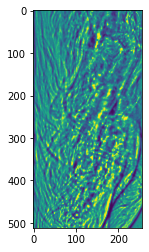

In [154]:
plt.imshow(smallerimages[0,:,:])